In [15]:
import sqlite3
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point, MultiPoint
from matplotlib_venn import venn3

In [16]:
# Connect to the databases
deliveroo_conn = sqlite3.connect("./databases/deliveroo.db")
takeaway_conn = sqlite3.connect("./databases/takeaway.db")
ubereats_conn = sqlite3.connect("./databases/ubereats.db")
# Create cursors
deliveroo = deliveroo_conn.cursor()
takeaway = takeaway_conn.cursor()
ubereats = ubereats_conn.cursor()

## Price distribution of menu items


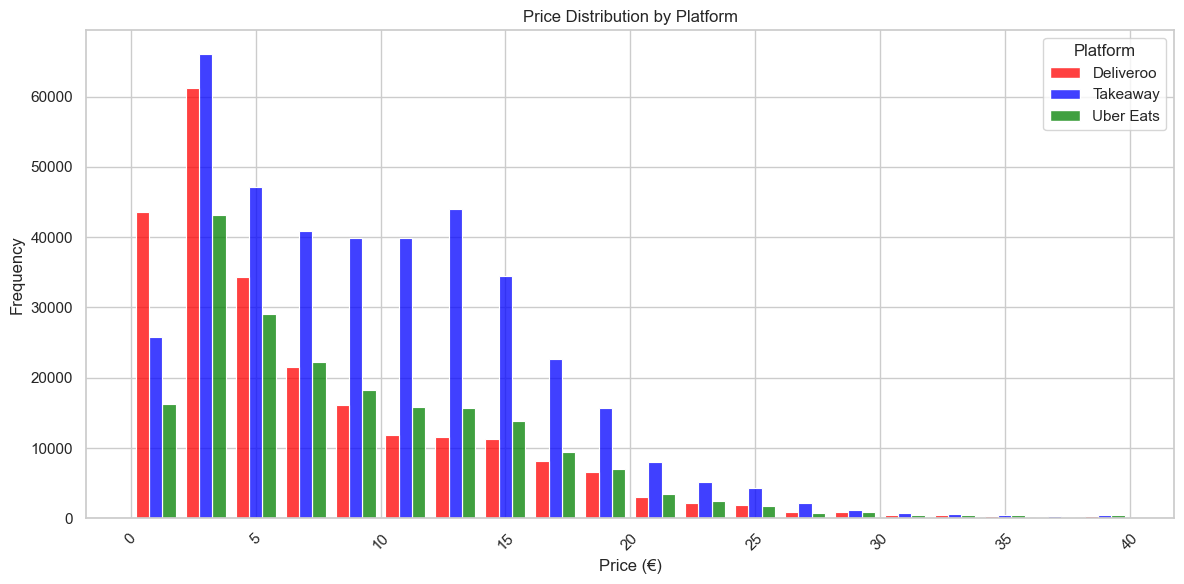

In [17]:
deliveroo.execute(
    """
    SELECT price
    FROM menu_items
    WHERE price >= '0.1'
    ORDER BY price ASC;"""
)
takeaway.execute(
    """
    SELECT price 
    FROM menuItems
    WHERE price >= 0.1
    ORDER BY price ASC;"""
)
ubereats.execute(
    """
    SELECT (price/100.0)
    FROM menu_items
    WHERE price >= 0.1
    ORDER BY price ASC;"""
)

price_list_deliveroo = deliveroo.fetchall()
price_list_deliveroo = [float(item[0]) for item in price_list_deliveroo]
min_price_deliveroo = price_list_deliveroo[0]
max_price_deliveroo = price_list_deliveroo[-1]
price_list_deliveroo = pd.DataFrame(price_list_deliveroo, columns=["Price"])
price_list_deliveroo["Platform"] = "Deliveroo"
price_list_deliveroo["Price"].apply(lambda x: x / 100 if x > 250 else x)

price_list_takeaway = takeaway.fetchall()
price_list_takeaway = [float(item[0]) for item in price_list_takeaway]
min_price_takeaway = price_list_takeaway[0]
max_price_takeaway = price_list_takeaway[-1]
price_list_takeaway = pd.DataFrame(price_list_takeaway, columns=["Price"])
price_list_takeaway["Platform"] = "Takeaway"


price_list_ubereats = ubereats.fetchall()
price_list_ubereats = [float(item[0]) for item in price_list_ubereats]
min_price_ubereats = price_list_ubereats[0]
max_price_ubereats = price_list_ubereats[-1]
price_list_ubereats = pd.DataFrame(price_list_ubereats, columns=["Price"])
price_list_ubereats["Platform"] = "Uber Eats"


combined_df = pd.concat(
    [price_list_deliveroo, price_list_takeaway, price_list_ubereats]
)

# Calculate the global min and max for consistent binning across platforms
global_min = combined_df["Price"].min()
# global max is 250 (incorrectly expressed as cents by deliveroo)
global_max = 250

# Create 10 bins
n_bins = 20
bins = np.linspace(0, 40, n_bins + 1)

# Create a figure with larger size
plt.figure(figsize=(12, 6))

# Create the histogram with side-by-side bars
# Position the bars for each platform next to each other within each bin
sns.histplot(
    data=combined_df,
    x="Price",
    hue="Platform",
    bins=bins,
    multiple="dodge",
    shrink=0.8,
    palette={"Deliveroo": "red", "Uber Eats": "green", "Takeaway": "blue"},
)

# Customize the plot
plt.title("Price Distribution by Platform")
plt.xlabel("Price (€)")
plt.ylabel("Frequency")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [18]:
geographic_df = gpd.read_file("./geodata/postaldistricts.shp")
geographic_df.rename(columns={"nouveau_PO": "PostalCode"}, inplace=True)
geographic_df["PostalCode"] = geographic_df["PostalCode"].astype("int64")
geographic_df.head()

,Join_Count,PostalCode,FREQUENCY,CP_speciau,Shape_Leng,Shape_Area,geometry
0,1,5012,2,1,977.714223,3.838034e+04,"POLYGON Z ((185640.749 128034.551 0, 185693.14..."
1,1,5012,2,1,123.021423,8.601421e+02,"POLYGON Z ((185785.522 128270.324 0, 185777.35..."
2,1,5589,1,1,1197.205234,6.306885e+04,"POLYGON Z ((213820.048 94558.92 0, 214146.309 ..."
3,1094,5560,2,0,54736.127330,5.406061e+07,"POLYGON Z ((191350.123 101346.457 0, 191368.11..."
4,1357,5370,1,0,74754.001683,8.154068e+07,"POLYGON Z ((210593.768 123259.25 0, 211182.758..."


## 2. What is the distribution of restaurants per location?


<Axes: >

<Figure size 1500x1500 with 0 Axes>

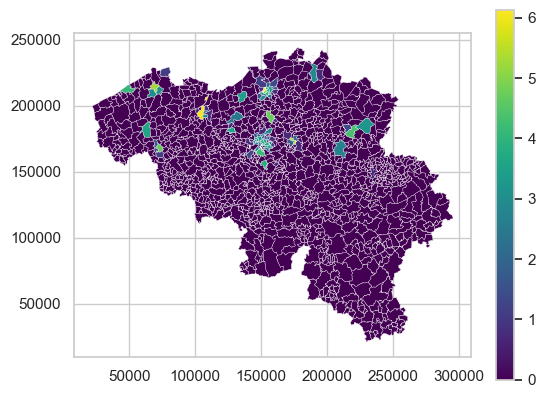

In [ ]:
query = """
SELECT r.postal_code AS PostalCode, COUNT(r.id) AS RestaurantCount
FROM restaurants r
GROUP BY r.postal_code
"""

location_dist = pd.read_sql_query(query, deliveroo_conn)
location_dist["PostalCode"] = pd.to_numeric(
    location_dist["PostalCode"], errors="coerce"
)
dist = geographic_df.merge(location_dist, on="PostalCode", how="left").fillna(0)
dist["RestaurantCountLog"] = dist["RestaurantCount"].apply(lambda x: np.log1p(x))
dist.plot("RestaurantCountLog", legend=True, linewidth=0.2, cmap="viridis")

<Axes: >

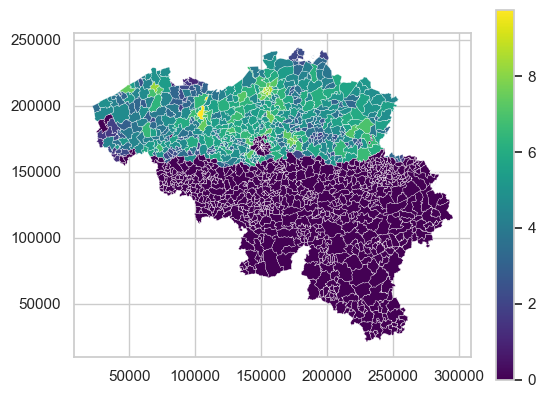

In [46]:
query = """
SELECT l.postalCode AS PostalCode, COUNT(r.restaurant_id) AS RestaurantCount
FROM restaurants r
JOIN locations_to_restaurants ltr ON r.primarySlug = ltr.restaurant_id
JOIN locations l ON ltr.location_id = l.ID
GROUP BY l.postalCode
"""

location_dist = pd.read_sql_query(query, takeaway_conn)
dist = geographic_df.merge(location_dist, on="PostalCode", how="left").fillna(0)
dist["RestaurantCountLog"] = dist["RestaurantCount"].apply(lambda x: np.log1p(x))
dist.plot("RestaurantCountLog", legend=True, linewidth=0.2, cmap="viridis")

<Axes: >

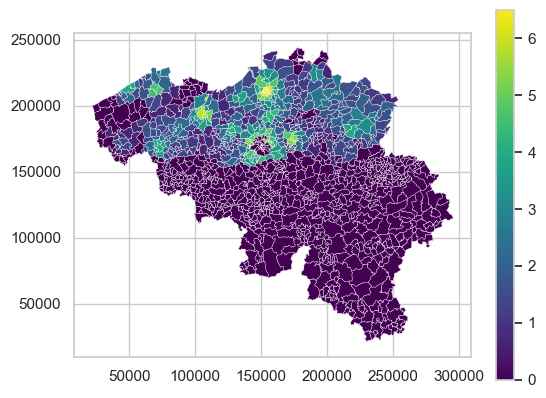

In [ ]:
query = """
SELECT DISTINCT r.title, l.name, l.region AS PostalCode, COUNT(DISTINCT r.title) AS RestaurantCount
FROM restaurants r
JOIN locations_to_restaurants ltr ON r.id = ltr.restaurant_id
JOIN locations l ON ltr.location_id = l.id
GROUP BY PostalCode
"""

location_dist = pd.read_sql_query(query, ubereats_conn)
location_dist["PostalCode"] = pd.to_numeric(
    location_dist["PostalCode"], errors="coerce"
)
dist = geographic_df.merge(location_dist, on="PostalCode", how="left").fillna(0)
dist["RestaurantCountLog"] = dist["RestaurantCount"].apply(lambda x: np.log1p(x))
dist.plot("RestaurantCountLog", legend=True, linewidth=0.2, cmap="viridis")

# 4. Map locations offering kapsalons and their average price.


<Axes: >

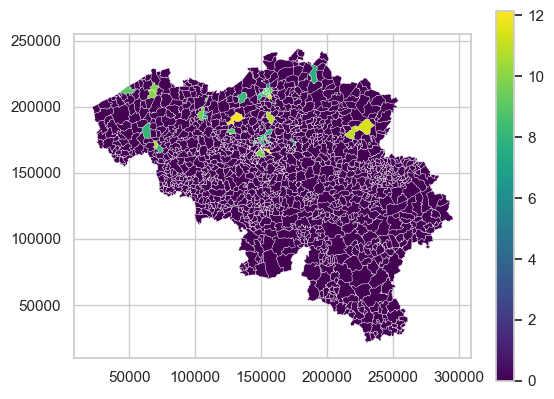

In [52]:
query = """
SELECT r.postal_code AS PostalCode, c.name, AVG(mi.price) AS price
FROM restaurants r
JOIN categories c ON r.id = c.restaurant_id
JOIN menu_items mi ON c.categorie_id = mi.categorie_id
WHERE c.name LIKE '%kapsalon%'
GROUP BY r.postal_code
"""

data = pd.read_sql_query(query, deliveroo_conn)
data["PostalCode"] = pd.to_numeric(data["PostalCode"], errors="coerce")
dist = geographic_df.merge(data, on="PostalCode", how="left").fillna(0)
dist.plot("price", legend=True, linewidth=0.2, cmap="viridis")

<Axes: >

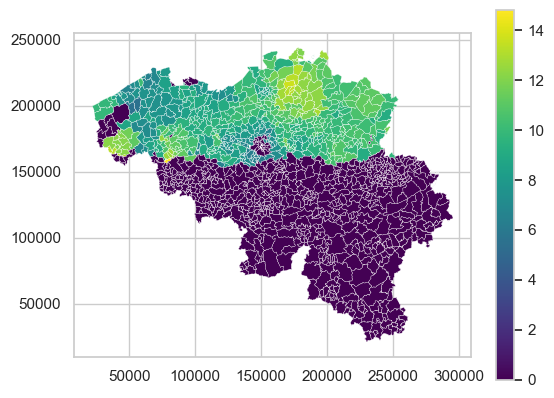

In [53]:
query = """
SELECT c.name AS category, AVG(m.price) AS price, l.postalCode AS PostalCode
FROM restaurants r
JOIN menuItems m ON r.primarySlug = m.primarySlug
JOIN categories c ON r.primarySlug = c.restaurant_id
JOIN locations_to_restaurants ltr ON r.primarySlug = ltr.restaurant_id
JOIN locations l ON ltr.location_id = l.ID
WHERE c.name LIKE '%kapsalon%'
GROUP BY PostalCode
ORDER BY price DESC
"""

data = pd.read_sql_query(query, takeaway_conn)
dist = geographic_df.merge(data, on="PostalCode", how="left").fillna(0)
dist.plot("price", legend=True, linewidth=0.2, cmap="viridis")

<Axes: >

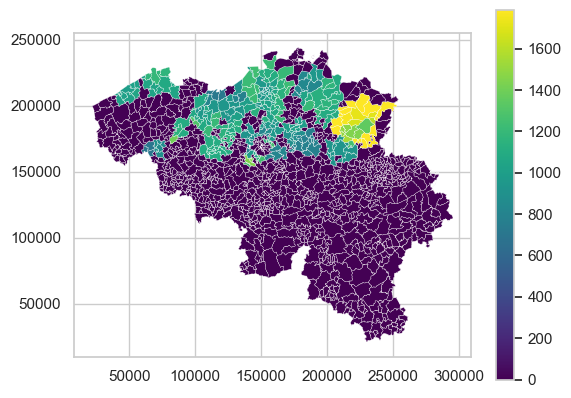

In [56]:
query = """
SELECT r.title, AVG(mi.price) AS price, l.region AS PostalCode, rtc.category, mi.name
FROM restaurants r
JOIN menu_items mi ON r.id = mi.restaurant_id
JOIN locations_to_restaurants ltr ON r.id = ltr.restaurant_id
JOIN locations l ON ltr.location_id = l.id
JOIN restaurant_to_categories rtc ON r.id = rtc.restaurant_id
WHERE mi.name LIKE '%kapsalon%'
GROUP BY PostalCode
"""

data = pd.read_sql_query(query, ubereats_conn)
data.head()
data["PostalCode"] = pd.to_numeric(data["PostalCode"], errors="coerce")
dist = geographic_df.merge(data, on="PostalCode", how="left").fillna(0)
dist.plot("price", legend=True, linewidth=0.2, cmap="viridis")

## Farthest point from a coke


In [25]:
deliveroo.execute(
    """
        SELECT l.name AS location, l.latitude as latitude, l.longitude as longitude
        FROM menu_items AS mi
        INNER JOIN restaurants AS r
        ON mi.restaurant_id = r.id
        INNER JOIN locations_to_restaurants AS lr
        ON r.id = lr.restaurant_id
        INNER JOIN locations AS l
        ON l.id = lr.location_id
        WHERE (mi.name LIKE '%coca%' OR mi.name LIKE '%coke%')AND mi.price >= '0.1'
        GROUP BY location,r.name,l.latitude,l.longitude;
    """
)
coke_restaurants_deliveroo = deliveroo.fetchall()
coke_restaurants_deliveroo = [list(item) for item in coke_restaurants_deliveroo]
coke_restaurants_deliveroo_df = pd.DataFrame(
    coke_restaurants_deliveroo, columns=["location", "latitude", "longitude"]
)

takeaway.execute(
    """
    SELECT l.name, l.latitude, l.longitude
    FROM restaurants AS r
    INNER JOIN menuItems m ON m.primarySlug = r.primarySlug
    INNER JOIN locations_to_restaurants loc ON loc.restaurant_id = r.primarySlug
    INNER JOIN locations l ON l.ID = loc.location_id
    WHERE m.name LIKE '%coke%' OR m.name LIKE '%coca%' AND m.price >= '0.1'
    GROUP BY l.name,r.name,l.latitude,l.longitude
    """
)
coke_restaurants_takeaway = takeaway.fetchall()
coke_restaurants_takeaway = [list(item) for item in coke_restaurants_takeaway]
coke_restaurants_takeaway_df = pd.DataFrame(
    coke_restaurants_takeaway, columns=["location", "latitude", "longitude"]
)


ubereats.execute(
    """
        SELECT l.name AS location, l.latitude as latitude, l.longitude as longitude
        FROM menu_items AS mi
        INNER JOIN restaurants AS r
        ON mi.restaurant_id = r.id
        INNER JOIN locations_to_restaurants AS lr
        ON r.id = lr.restaurant_id
        INNER JOIN locations AS l
        ON l.id = lr.location_id
        WHERE (mi.name LIKE '%coca%' OR mi.name LIKE '%coke%')AND mi.price >= '0.1'
        GROUP BY location,r.sanitized_title,l.latitude,l.longitude;
    """
)
coke_restaurants_ubereats = ubereats.fetchall()
coke_restaurants_ubereats = [list(item) for item in coke_restaurants_ubereats]
coke_restaurants_ubereats_df = pd.DataFrame(
    coke_restaurants_ubereats, columns=["location", "latitude", "longitude"]
)

In [26]:
coke_restaurants = (
    coke_restaurants_deliveroo + coke_restaurants_takeaway + coke_restaurants_ubereats
)
coke_restaurants_df = pd.DataFrame(
    coke_restaurants, columns=["location", "latitude", "longitude"]
)
# drop duplicates based on same latitude and longitude
coke_restaurants_df.drop_duplicates(subset=["latitude", "longitude"], inplace=True)

In [27]:
# df = pd.read_csv("coke_restaurants.csv")
gdf = gpd.GeoDataFrame(
    coke_restaurants_df,
    geometry=gpd.points_from_xy(
        coke_restaurants_df.longitude, coke_restaurants_df.latitude
    ),
)
gdf = gdf.set_crs(epsg=4326)
belgium_map = gpd.read_file("geodata/gadm41_BEL_1.shp")

flanders = belgium_map.geometry[1]

# rig
min_x, min_y, max_x, max_y = flanders.bounds
x_range = np.linspace(min_x, max_x, 100)
y_range = np.linspace(min_y, max_y, 100)
# find x point that is most distant from all the plotted points:
max_distance = 0
farthest_point = None
for x in x_range:
    for y in y_range:
        point = Point(x, y)
        if point.within(flanders):
            distance = point.distance(MultiPoint(gdf.geometry.tolist()))
            if distance > max_distance:
                max_distance = distance
                farthest_point = point

/var/folders/z6/vnwrtwgd7x5chl_2vn910h6r0000gn/T/ipykernel_3462/3570698156.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(


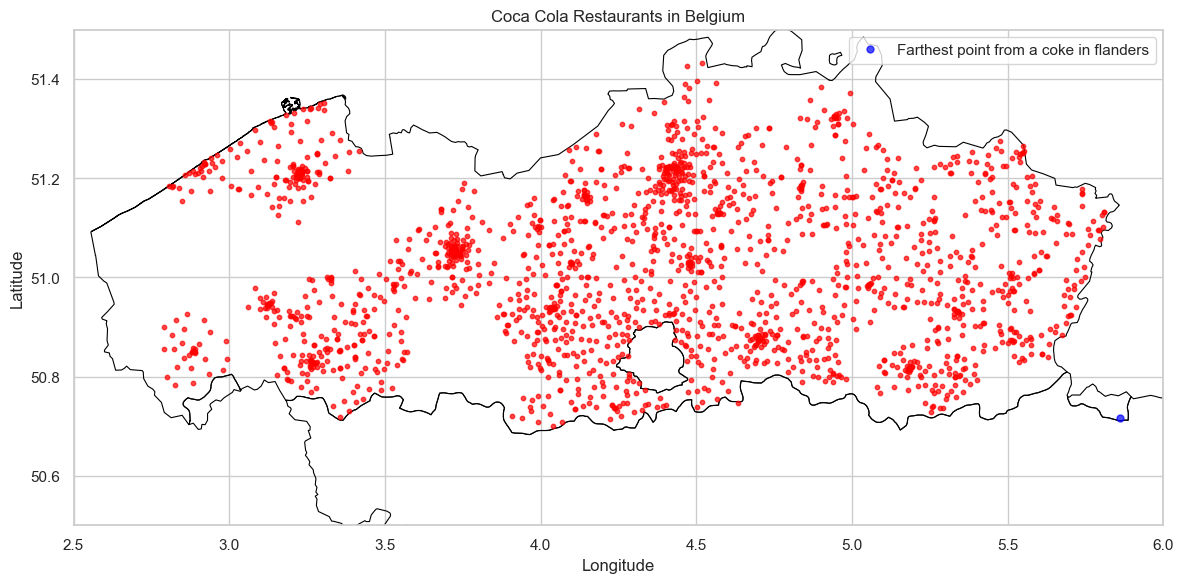

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))
belgium_map.plot(
    ax=ax, facecolor="none", linewidth=0.8, edgecolor="black", figsize=(12, 6)
)
gdf.plot(
    ax=ax,
    color="red",
    markersize=10,
    alpha=0.7,
)
ax.plot(
    farthest_point.x,
    farthest_point.y,
    "bo",
    markersize=5,
    label="Farthest point from a coke in flanders",
    alpha=0.7,
    color="blue",
)
# plot country bounds
plt.xlim(2.5, 6.0)
plt.ylim(50.5, 51.5)
plt.legend()

plt.title("Coca Cola Restaurants in Belgium")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

## 5. Top 10 pizza restaurants


/var/folders/z6/vnwrtwgd7x5chl_2vn910h6r0000gn/T/ipykernel_3462/1719415651.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


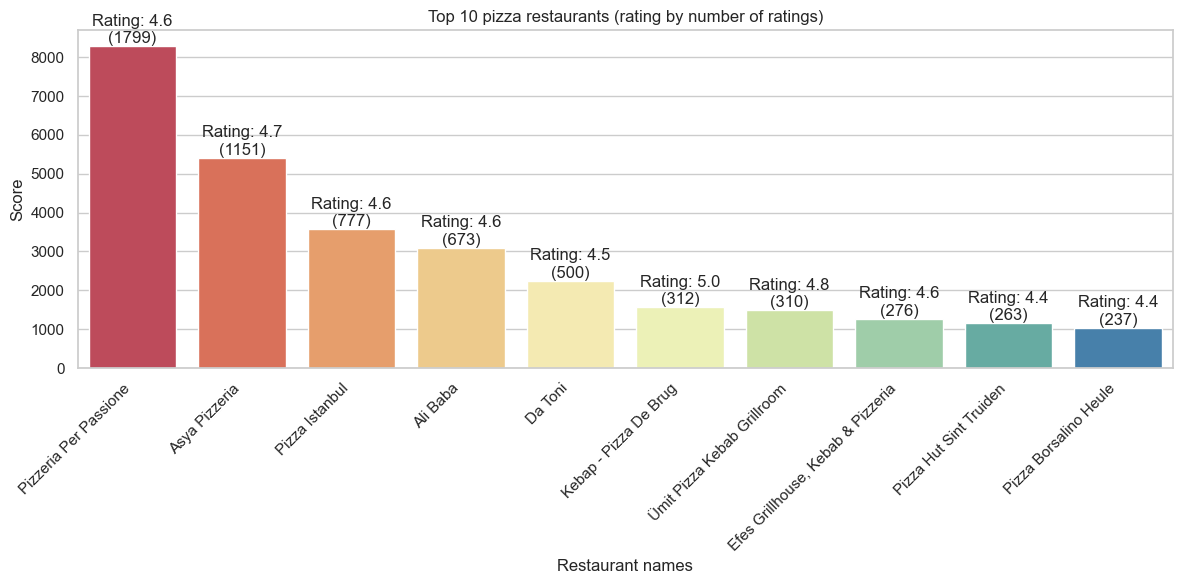

In [29]:
deliveroo.execute(
    """
        SELECT r.name, r.rating,r.rating_number
        FROM restaurants AS r
        INNER JOIN categories AS c
        ON r.id = c.restaurant_id
        WHERE c.name LIKE '%pizza%'AND r.category LIKE '%itali%'
        GROUP BY r.name
        ORDER BY r.rating DESC
        LIMIT 10;
    """
)
resto_list_deliveroo = deliveroo.fetchall()
resto_list_deliveroo = [list(item) for item in resto_list_deliveroo]
resto_list_deliveroo_df = pd.DataFrame(
    resto_list_deliveroo, columns=["name", "rating", "rating_count"]
)
# print(resto_list_deliveroo)
takeaway.execute(
    """
        SELECT r.name, r.ratings AS rating,r.ratingsNumber
        FROM restaurants AS r
        JOIN categories AS c ON c.restaurant_id = r.primarySlug
        JOIN menuItems AS mi ON mi.primarySlug = r.primarySlug
        WHERE c.name LIKE '%itali%' and mi.name LIKE '%pizza%' 
        GROUP BY r.name
        ORDER BY rating DESC
        LIMIT 10
    """
)
resto_list_takeaway = takeaway.fetchall()
resto_list_takeaway = [list(item) for item in resto_list_takeaway]
resto_list_takeaway_df = pd.DataFrame(
    resto_list_takeaway, columns=["name", "rating", "rating_count"]
)


ubereats.execute(
    """
    SELECT restaurants.title, restaurants.rating__rating_value, restaurants.rating__review_count FROM restaurant_to_categories
    INNER JOIN restaurants ON restaurant_to_categories.restaurant_id=restaurants.id
    INNER JOIN menu_items ON menu_items.restaurant_id=restaurants.id
    WHERE menu_items.name LIKE '%pizza%' AND restaurant_to_categories.category LIKE '%ital%'
    GROUP BY restaurants.title
    ORDER BY restaurants.rating__rating_value DESC
    LIMIT 10
    """
)

resto_list_ubereats = ubereats.fetchall()
resto_list_ubereats = [list(item) for item in resto_list_ubereats]
resto_list_ubereats_df = pd.DataFrame(
    resto_list_ubereats, columns=["name", "rating", "rating_count"]
)

combined_top_pizzas = pd.concat(
    [resto_list_deliveroo_df, resto_list_takeaway_df, resto_list_ubereats_df]
)

combined_top_pizzas["rating_count"] = combined_top_pizzas["rating_count"].apply(
    lambda x: x.replace("+", "") if type(x) == str else x
)
combined_top_pizzas["rating_count"] = combined_top_pizzas["rating_count"].astype(int)
combined_top_pizzas["rating_times_count"] = (
    combined_top_pizzas["rating"] * combined_top_pizzas["rating_count"]
)

combined_top_pizzas.sort_values(by="rating_times_count", ascending=False, inplace=True)
combined_top_pizzas = combined_top_pizzas.head(10)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=combined_top_pizzas["name"],
    y=combined_top_pizzas["rating_times_count"],
    palette="Spectral",
    data=combined_top_pizzas,
)

for i in range(len(combined_top_pizzas)):
    rating = combined_top_pizzas["rating"].iloc[i]
    count = combined_top_pizzas["rating_count"].iloc[i]
    ax.text(
        i,
        combined_top_pizzas["rating_times_count"].iloc[i],
        f"Rating: {rating:.1f}\n({count})",
        ha="center",
        va="bottom",
    )

plt.title("Top 10 pizza restaurants (rating by number of ratings)")
plt.xlabel("Restaurant names")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 6. Create a Venn diagram comparing restaurant distributions across Uber Eats, Deliveroo, and Takeaway. Discuss trends.


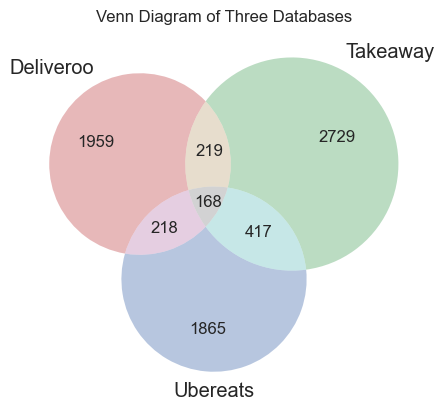

In [30]:
# Query unique names from each database
deliveroo.execute("SELECT DISTINCT name FROM restaurants")
ids1 = set(row[0] for row in deliveroo.fetchall())
takeaway.execute("SELECT DISTINCT name FROM restaurants")
ids2 = set(row[0] for row in takeaway.fetchall())
ubereats.execute("SELECT DISTINCT r.title FROM restaurants r")
ids3 = set(row[0] for row in ubereats.fetchall())

# Unique to each database
only_in_1 = ids1 - ids2 - ids3
only_in_2 = ids2 - ids1 - ids3
only_in_3 = ids3 - ids1 - ids2
# Pairwise overlaps
in_1_and_2 = (ids1 & ids2) - ids3
in_1_and_3 = (ids1 & ids3) - ids2
in_2_and_3 = (ids2 & ids3) - ids1
# Overlap in all three
in_all = ids1 & ids2 & ids3

# Sizes for the Venn diagram
venn = venn3(
    subsets=(
        len(only_in_1),  # Unique to DB1
        len(only_in_2),  # Unique to DB2
        len(in_1_and_2),  # Shared by DB1 and DB2
        len(only_in_3),  # Unique to DB3
        len(in_1_and_3),  # Shared by DB1 and DB3
        len(in_2_and_3),  # Shared by DB2 and DB3
        len(in_all),  # Shared by all three
    ),
    set_labels=("Deliveroo", "Takeaway", "Ubereats"),
)

# Customize the plot
plt.title("Venn Diagram of Three Databases")
plt.show()

## 7. How do delivery fees vary across platforms and locations?


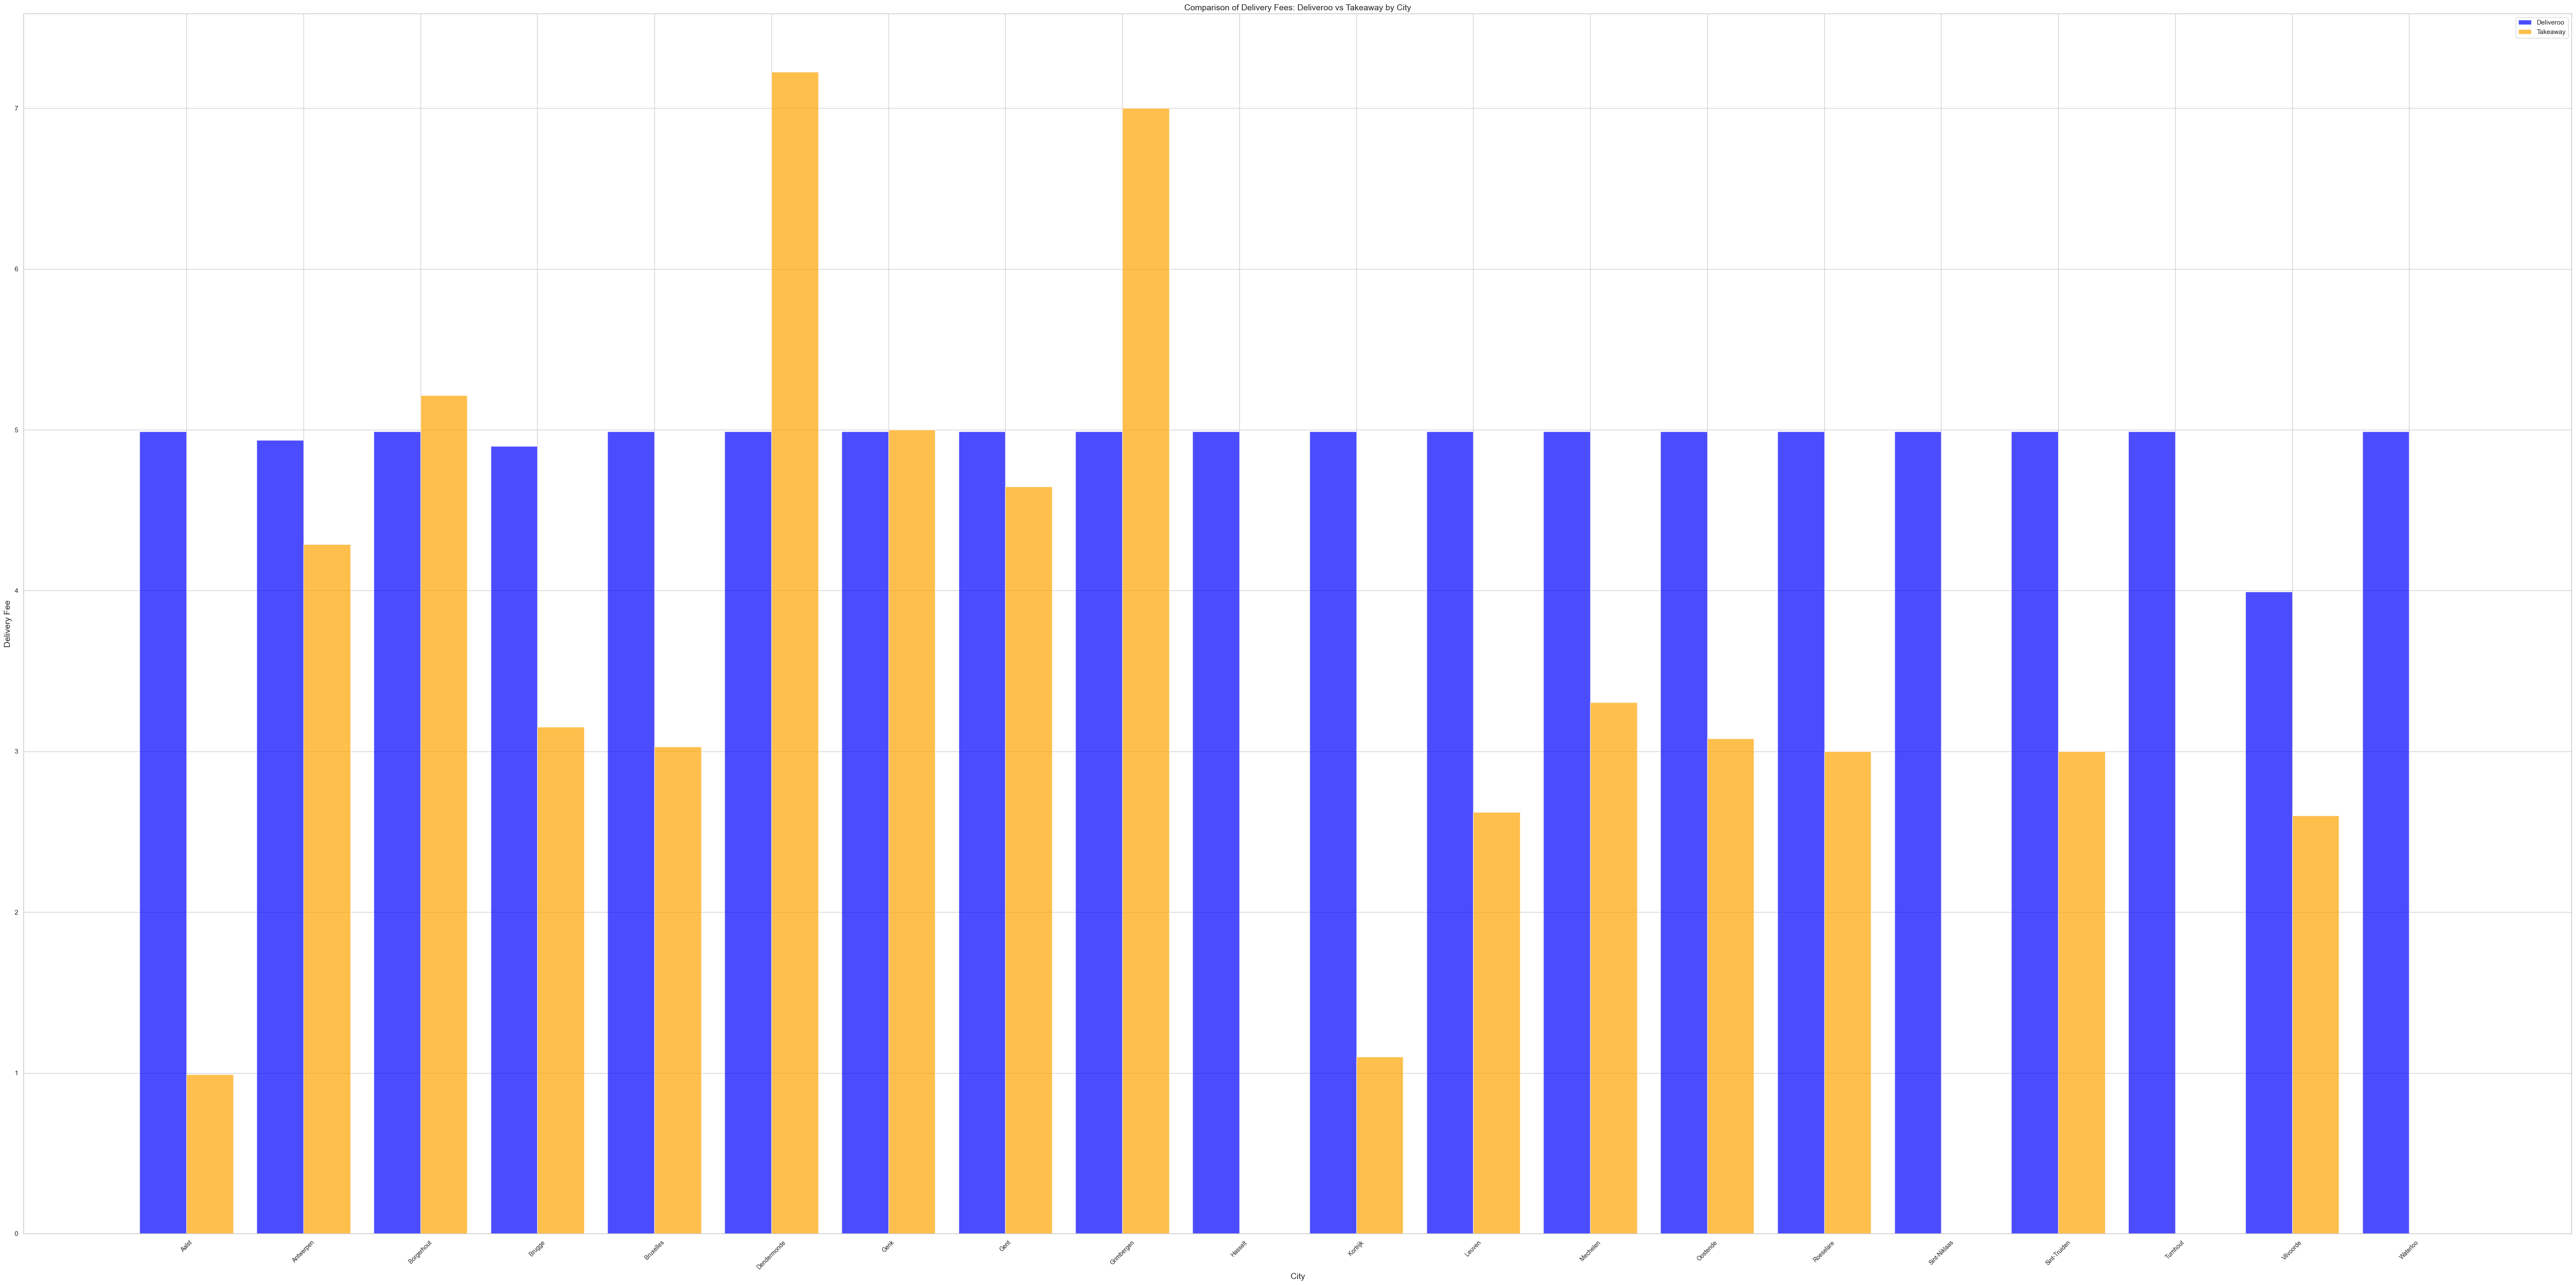

In [31]:
# Queries for fetching data from both databases
query = "SELECT name, delivery_fee, latitude, longitude FROM restaurants"
query1 = "SELECT city, deliveryFee, latitude, longitude FROM restaurants"

# Fetching data from the two connections
data = pd.read_sql_query(query, deliveroo_conn)
data1 = pd.read_sql_query(query1, takeaway_conn)

# Renaming columns for consistency
data.rename(columns={"delivery_fee": "deliveryFee"}, inplace=True)

# Ensure deliveryFee columns are numeric
data["deliveryFee"] = pd.to_numeric(data["deliveryFee"], errors="coerce")
data1["deliveryFee"] = pd.to_numeric(data1["deliveryFee"], errors="coerce")

# Merging the two datasets based on latitude and longitude
merged_data = pd.merge(
    data, data1, on=["latitude", "longitude"], suffixes=("_deliveroo", "_takeaway")
)

# Adding a column to calculate the numeric difference
merged_data["fee_difference"] = (
    merged_data["deliveryFee_deliveroo"] - merged_data["deliveryFee_takeaway"]
)

Fees = merged_data[merged_data["fee_difference"] != 0]

# by restaurant
Fees = Fees.drop(columns=["latitude", "longitude"])

# by city
FeesbyCity = Fees.drop(columns=["name"])


city_mapping = {
    "Schaarbeek": "Bruxelles",
    "Anvers": "Antwerpen",
    "Alost": "Aalst",
    "Bruges": "Brugge",
    "Courtrai": "Kortrijk",
    "Malines": "Mechelen",
    "Ostende": "Oostende",
    "Roulers": "Roeselare",
    "Saint-Nicolas": "Sint-Niklaas",
    "Termonde": "Dendermonde",
    "Tournai": "Doornik",
    "Ypres": "Ieper",
    "Zottegem": "Bruxelles",
    "Woluwé-Saint-Lambert": "Bruxelles",
    "Woluwe-Saint-Pierre": "Bruxelles",
    "Woluwé-Saint-Pierre": "Bruxelles",
    "Sint-Pieters-Leeuw": "Bruxelles",
    "Gand": "Gent",
    "Uccle": "Bruxelles",
    "Vilvorde": "Vilvoorde",
    "Borgherout": "Antwerpen",
    "Berchem": "Antwerpen",
    "Wilrijk": "Antwerpen",
    "Evere": "Bruxelles",
    "Forest": "Bruxelles",
    "Berchem-Sainte-Agathe": "Bruxelles",
    "Drogenbos": "Bruxelles",
    "Ganshoren": "Bruxelles",
    "Jette": "Bruxelles",
    "Heverlee": "Leuven",
    "Kessel-Lo": "Leuven",
    "Kraainem": "Bruxelles",
    "Laeken": "Bruxelles",
    "Molenbeek-Saint-Jean": "Bruxelles",
    "Ledeberg": "Gent",
    "Merksem": "Antwerpen",
    "Schaerbeek": "Bruxelles",
    "Strombeek-Bever": "Bruxelles",
    "Ukkel": "Bruxelles",
    "Wijnegem": "Antwerpen",
    "Wilrijk": "Antwerpen",
    "Sint-Andries": "Brugge",
    "Deurne": "Antwerpen",
}
# Standardize city names using the mapping
FeesbyCity["city"] = FeesbyCity["city"].replace(city_mapping)
FeesbyCity = FeesbyCity.groupby(by=["city"], as_index=False).mean()
FeesbyCity = FeesbyCity.drop(index=0)


# Export the Fees to a CSV file
Fees.to_csv("Fees.csv", index=False)
FeesbyCity.to_csv("FeesByCity.csv", index=False)
# Create a bar plot comparing fees from Deliveroo and Takeaway by city
fig, ax = plt.subplots(figsize=(60, 30))

# Plot the delivery fees side by side
x = range(len(FeesbyCity))
width = 0.4

ax.bar(
    x,
    FeesbyCity["deliveryFee_deliveroo"],
    width=width,
    label="Deliveroo",
    color="blue",
    alpha=0.7,
)
ax.bar(
    [i + width for i in x],
    FeesbyCity["deliveryFee_takeaway"],
    width=width,
    label="Takeaway",
    color="orange",
    alpha=0.7,
)

# Add labels, title, and legend
ax.set_xlabel("City", fontsize=14)
ax.set_ylabel("Delivery Fee", fontsize=14)
ax.set_title("Comparison of Delivery Fees: Deliveroo vs Takeaway by City", fontsize=14)
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(FeesbyCity["city"], rotation=45, fontsize=10)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

## 8. Which restaurants have the best price-to-rating ratio?


In [32]:
query = """
SELECT r.name, (AVG(r.rating) / SUM(mi.price)) AS ratio
FROM restaurants r
JOIN categories c ON r.id = c.restaurant_id
JOIN menu_items mi ON c.categorie_id = mi.categorie_id
GROUP BY r.name
ORDER BY ratio DESC
"""

data = pd.read_sql_query(query, deliveroo_conn)
data.head()

,name,ratio
0,Carrefour Express Voskenslaan,0.249680
1,Stadsbrouwerij De Koninck,0.242105
2,#Kitchens,0.232432
3,Café Pistolet,0.219048
4,Bubble Land,0.186667


In [33]:
query = """
SELECT r.name, (AVG(r.ratings) / SUM(mi.price)) AS ratio
FROM restaurants r
JOIN menuItems mi ON r.primarySlug = mi.primarySlug
GROUP BY r.name
ORDER BY ratio DESC
"""

data = pd.read_sql_query(query, takeaway_conn)
data.head()

,name,ratio
0,El Bocadillos,0.350000
1,Pâtisserie Doce Tentação,0.238095
2,Hard Rock Cafe,0.183529
3,Rumah Jawa,0.177778
4,Au Petit En Cas (chez Lucie),0.157692


In [34]:
query = """
SELECT r.title, (AVG(r.rating__rating_value) / SUM(mi.price)) AS ratio
FROM restaurants r
JOIN menu_items mi ON r.id = mi.restaurant_id
GROUP BY r.title
ORDER BY ratio DESC
"""

data = pd.read_sql_query(query, ubereats_conn)
data.head()

,title,ratio
0,So Sushi Dilbeek,0.015000
1,RUBA - Healthy Fresh Food,0.013143
2,O'Tacos - Mechelen,0.011429
3,PokÃ© House - Antwerpen,0.009250
4,Belchicken - Basilix,0.008039


## 10. Vegan/Vegetarian dishes availability by area


In [35]:
# Deliveroo Query
deliveroo.execute(
    """
    SELECT 
        l.name AS location,
        l.latitude,
        l.longitude,
        r.name AS restaurant_name,
        COUNT(DISTINCT CASE WHEN LOWER(mi.name) LIKE '%vegan%' THEN mi.id END) AS vegan_items,
        COUNT(DISTINCT CASE WHEN LOWER(mi.name) LIKE '%veg%' AND LOWER(mi.name) NOT LIKE '%vegan%' THEN mi.id END) AS vegetarian_items,
        COUNT(DISTINCT mi.id) AS total_items,
        ROUND(CAST(COUNT(DISTINCT CASE WHEN LOWER(mi.name) LIKE '%vegan%' THEN mi.id END) AS FLOAT) * 100 / 
              NULLIF(COUNT(DISTINCT mi.id), 0), 2) AS vegan_percentage,
        ROUND(CAST(COUNT(DISTINCT CASE WHEN LOWER(mi.name) LIKE '%veg%' AND LOWER(mi.name) NOT LIKE '%vegan%' THEN mi.id END) AS FLOAT) * 100 / 
              NULLIF(COUNT(DISTINCT mi.id), 0), 2) AS vegetarian_percentage
    FROM menu_items AS mi
    INNER JOIN restaurants AS r ON mi.restaurant_id = r.id
    INNER JOIN locations_to_restaurants AS lr ON r.id = lr.restaurant_id
    INNER JOIN locations AS l ON l.id = lr.location_id
    WHERE mi.price >= 0.1
    GROUP BY l.name, r.name, l.latitude, l.longitude
    """
)
vegetarian_vegan_restos_deliveroo = deliveroo.fetchall()
vegetarian_vegan_restos_deliveroo = [
    list(item) for item in vegetarian_vegan_restos_deliveroo
]
vegetarian_vegan_restos_deliveroo_df = pd.DataFrame(
    vegetarian_vegan_restos_deliveroo,
    columns=[
        "location",
        "latitude",
        "longitude",
        "restaurant_name",
        "vegan_items",
        "vegetarian_items",
        "total_items",
        "vegan_percentage",
        "vegetarian_percentage",
    ],
)

# Takeaway Query
takeaway.execute(
    """
    SELECT 
        l.name AS location,
        l.latitude,
        l.longitude,
        r.name AS restaurant_name,
        COUNT(DISTINCT CASE WHEN LOWER(m.name) LIKE '%vegan%' THEN m.id END) AS vegan_items,
        COUNT(DISTINCT CASE WHEN LOWER(m.name) LIKE '%veg%' AND LOWER(m.name) NOT LIKE '%vegan%' THEN m.id END) AS vegetarian_items,
        COUNT(DISTINCT m.id) AS total_items,
        ROUND(CAST(COUNT(DISTINCT CASE WHEN LOWER(m.name) LIKE '%vegan%' THEN m.id END) AS FLOAT) * 100 / 
              NULLIF(COUNT(DISTINCT m.id), 0), 2) AS vegan_percentage,
        ROUND(CAST(COUNT(DISTINCT CASE WHEN LOWER(m.name) LIKE '%veg%' AND LOWER(m.name) NOT LIKE '%vegan%' THEN m.id END) AS FLOAT) * 100 / 
              NULLIF(COUNT(DISTINCT m.id), 0), 2) AS vegetarian_percentage
    FROM restaurants AS r
    INNER JOIN menuItems m ON m.primarySlug = r.primarySlug
    INNER JOIN locations_to_restaurants loc ON loc.restaurant_id = r.primarySlug
    INNER JOIN locations l ON l.ID = loc.location_id
    WHERE m.price >= 0.1
    GROUP BY l.name, r.name, l.latitude, l.longitude
    """
)
vegetarian_vegan_restos_takeaway = takeaway.fetchall()
vegetarian_vegan_restos_takeaway = [
    list(item) for item in vegetarian_vegan_restos_takeaway
]
vegetarian_vegan_restos_takeaway_df = pd.DataFrame(
    vegetarian_vegan_restos_takeaway,
    columns=[
        "location",
        "latitude",
        "longitude",
        "restaurant_name",
        "vegan_items",
        "vegetarian_items",
        "total_items",
        "vegan_percentage",
        "vegetarian_percentage",
    ],
)

# UberEats Query
ubereats.execute(
    """
    SELECT 
        l.name AS location,
        l.latitude,
        l.longitude,
        r.sanitized_title AS restaurant_name,
        COUNT(DISTINCT CASE WHEN LOWER(mi.name) LIKE '%vegan%' THEN mi.id END) AS vegan_items,
        COUNT(DISTINCT CASE WHEN LOWER(mi.name) LIKE '%veg%' AND LOWER(mi.name) NOT LIKE '%vegan%' THEN mi.id END) AS vegetarian_items,
        COUNT(DISTINCT mi.id) AS total_items,
        ROUND(CAST(COUNT(DISTINCT CASE WHEN LOWER(mi.name) LIKE '%vegan%' THEN mi.id END) AS FLOAT) * 100 / 
              NULLIF(COUNT(DISTINCT mi.id), 0), 2) AS vegan_percentage,
        ROUND(CAST(COUNT(DISTINCT CASE WHEN LOWER(mi.name) LIKE '%veg%' AND LOWER(mi.name) NOT LIKE '%vegan%' THEN mi.id END) AS FLOAT) * 100 / 
              NULLIF(COUNT(DISTINCT mi.id), 0), 2) AS vegetarian_percentage
    FROM menu_items AS mi
    INNER JOIN restaurants AS r ON mi.restaurant_id = r.id
    INNER JOIN locations_to_restaurants AS lr ON r.id = lr.restaurant_id
    INNER JOIN locations AS l ON l.id = lr.location_id
    WHERE mi.price >= 0.1
    GROUP BY l.name, r.sanitized_title, l.latitude, l.longitude
    """
)
vegetarian_vegan_restos_ubereats = ubereats.fetchall()
vegetarian_vegan_restos_ubereats = [
    list(item) for item in vegetarian_vegan_restos_ubereats
]
vegetarian_vegan_restos_ubereats_df = pd.DataFrame(
    vegetarian_vegan_restos_ubereats,
    columns=[
        "location",
        "latitude",
        "longitude",
        "restaurant_name",
        "vegan_items",
        "vegetarian_items",
        "total_items",
        "vegan_percentage",
        "vegetarian_percentage",
    ],
)

# Combine all results
vegetarian_vegan_restos_combined = (
    vegetarian_vegan_restos_deliveroo
    + vegetarian_vegan_restos_takeaway
    + vegetarian_vegan_restos_ubereats
)
vegetarian_vegan_restos_combined_df = pd.DataFrame(
    vegetarian_vegan_restos_combined,
    columns=[
        "location",
        "latitude",
        "longitude",
        "restaurant_name",
        "vegan_items",
        "vegetarian_items",
        "total_items",
        "vegan_percentage",
        "vegetarian_percentage",
    ],
)

# Remove duplicates based on location and restaurant name
vegetarian_vegan_restos_combined_df.drop_duplicates(
    subset=["latitude", "longitude", "restaurant_name"], inplace=True
)

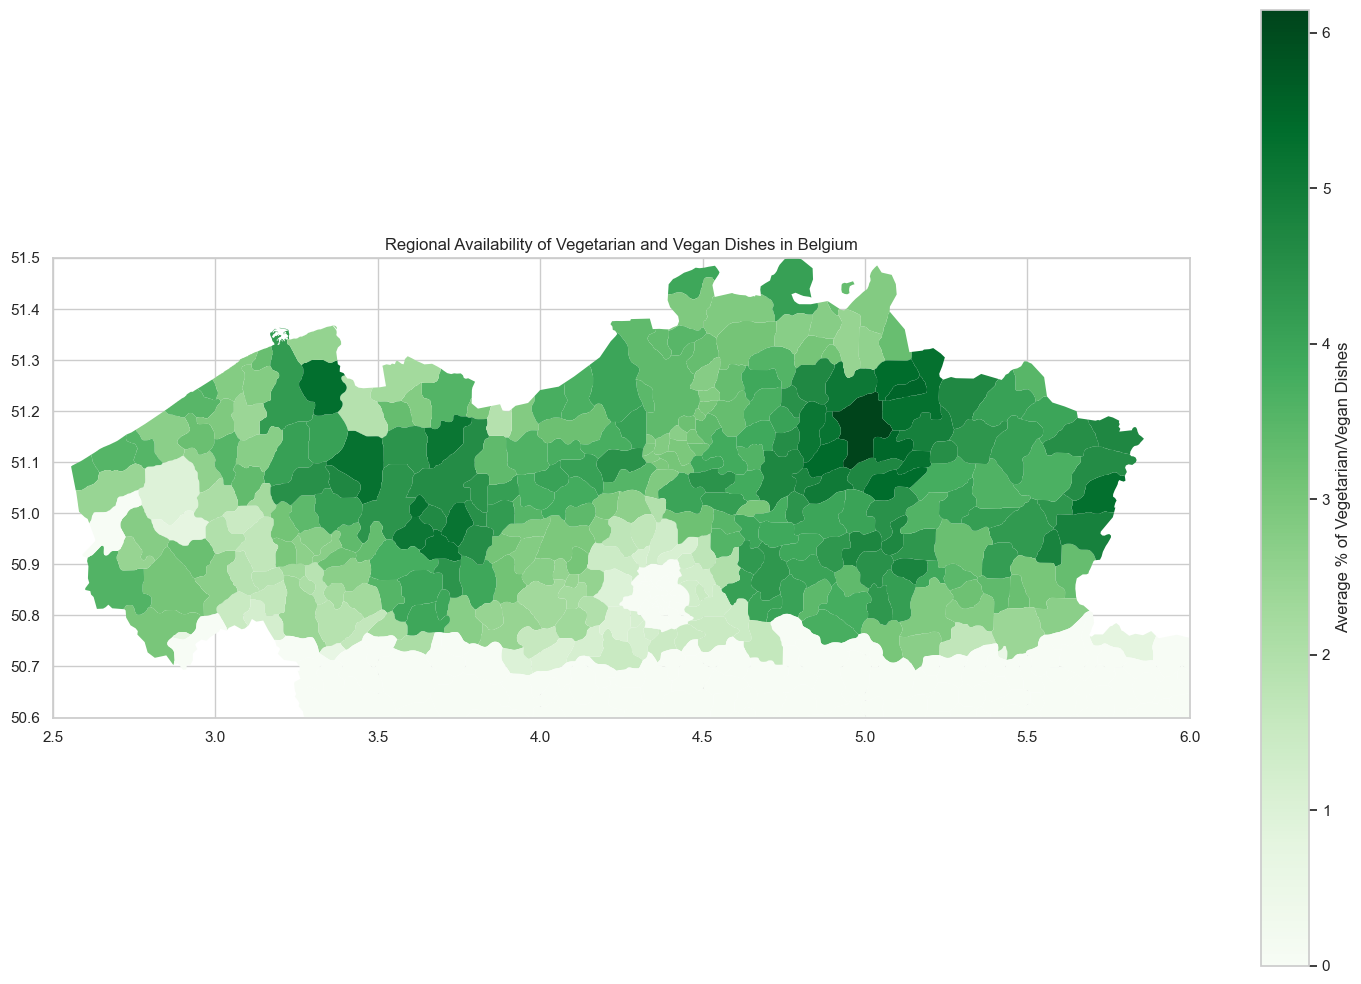


Top 5 regions by vegetarian/vegan availability:
City: Geel
City: Dessel
City: Meerhout
City: Westerlo
City: Retie


In [36]:
belgium_map_vegetarian = gpd.read_file("geodata/gadm41_BEL_4.shp")


def get_region_stats(region_geometry, restaurants_gdf):
    # Find restaurants within the region
    mask = restaurants_gdf.within(region_geometry)
    restaurants_in_region = restaurants_gdf[mask]

    if len(restaurants_in_region) < 3:  # Minimum threshold for meaningful statistics
        return 0

    # Calculate average percentages for the region
    avg_veg_percentage = (
        restaurants_in_region["vegetarian_percentage"]
        + restaurants_in_region["vegan_percentage"]
    ).mean()

    return avg_veg_percentage


# Create GeoDataFrame from restaurants data
gdf_restaurants = gpd.GeoDataFrame(
    vegetarian_vegan_restos_combined_df,
    geometry=gpd.points_from_xy(
        vegetarian_vegan_restos_combined_df.longitude,
        vegetarian_vegan_restos_combined_df.latitude,
    ),
)
gdf_restaurants = gdf_restaurants.set_crs(epsg=4326)

# Calculate average vegetarian/vegan percentage for each region
belgium_map_vegetarian["veg_percentage"] = belgium_map_vegetarian.geometry.apply(
    lambda x: get_region_stats(x, gdf_restaurants)
)

# Create the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Plot regions with a continuous color scale based on veg percentage
belgium_map_vegetarian.plot(
    ax=ax,
    column="veg_percentage",
    legend=True,
    legend_kwds={
        "label": "Average % of Vegetarian/Vegan Dishes",
        "orientation": "vertical",
    },
    missing_kwds={"color": "lightgrey"},
    # add cmap with shades of green
    cmap="Greens",
    linewidth=0,
    edgecolor="black",
)

# Customize the plot
plt.xlim(2.5, 6.0)
plt.ylim(50.6, 51.5)
plt.title("Regional Availability of Vegetarian and Vegan Dishes in Belgium")

# Add summary statistics
total_restaurants = len(gdf_restaurants)
regions_with_data = belgium_map_vegetarian[belgium_map_vegetarian["veg_percentage"] > 0]

plt.tight_layout()
plt.show()

# Print detailed statistics for regions
print("\nTop 5 regions by vegetarian/vegan availability:")
top_regions = belgium_map_vegetarian[
    belgium_map_vegetarian["veg_percentage"] > 0
].nlargest(5, "veg_percentage")
for idx, row in top_regions.iterrows():
    print(f"City: {row.NAME_4}")

## 11. How do ratings of similar restaurants differ across Uber Eats, Deliveroo, and Takeaway?


In [37]:
db1_df = pd.read_sql_query(
    "SELECT r.name AS name, r.rating AS rating FROM restaurants r", deliveroo_conn
)
db2_df = pd.read_sql_query(
    "SELECT r.name AS name, r.ratings AS rating FROM restaurants r", takeaway_conn
)
db3_df = pd.read_sql_query(
    "SELECT r.title AS name, r.rating__rating_value AS rating FROM restaurants r",
    ubereats_conn,
)

# Normalize names for comparison
db1_df["normalized_name"] = (
    db1_df["name"].str.lower().str.replace(" ", "").str.replace("'", "")
)
db2_df["normalized_name"] = (
    db2_df["name"].str.lower().str.replace(" ", "").str.replace("'", "")
)
db3_df["normalized_name"] = (
    db3_df["name"].str.lower().str.replace(" ", "").str.replace("'", "")
)

db3_df.rename(columns={"rating": "rating_db3"}, inplace=True)
# Merge DataFrames on normalized names
merged = db1_df.merge(
    db2_df, on="normalized_name", how="inner", suffixes=("_db1", "_db2")
)
merged = merged.merge(db3_df, on="normalized_name", how="inner", suffixes=("", "_db3"))

merged["rating_diff_db1_db2"] = merged["rating_db1"] - merged["rating_db2"]
merged["rating_diff_db1_db3"] = merged["rating_db1"] - merged["rating_db3"]
merged["rating_diff_db2_db3"] = merged["rating_db2"] - merged["rating_db3"]

data = merged.iloc[:15]

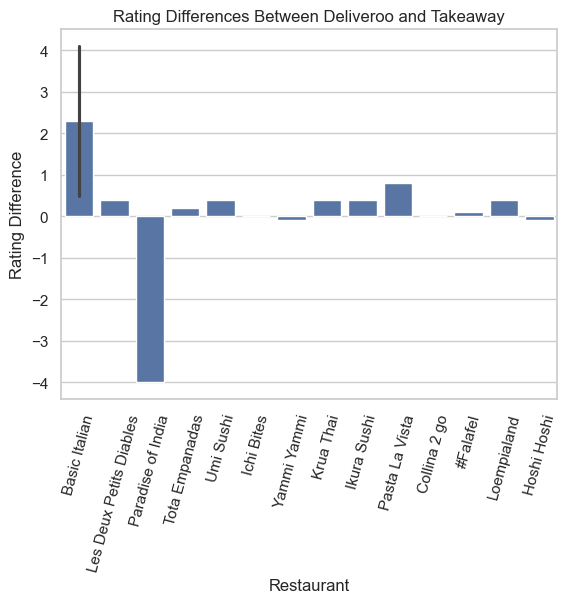

In [38]:
sns.barplot(data, x="name_db1", y="rating_diff_db1_db2")
plt.xticks(rotation=75)
plt.title("Rating Differences Between Deliveroo and Takeaway")
plt.ylabel("Rating Difference")
plt.xlabel("Restaurant")
plt.show()

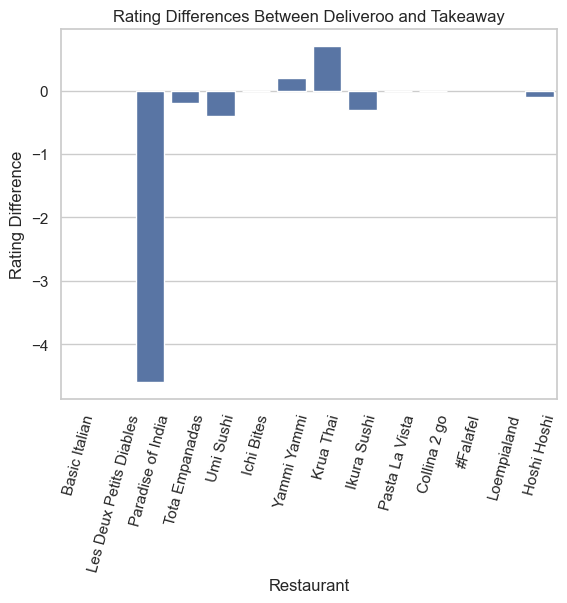

In [39]:
sns.barplot(data, x="name_db1", y="rating_diff_db1_db3")
plt.xticks(rotation=75)
plt.title("Rating Differences Between Deliveroo and Takeaway")
plt.ylabel("Rating Difference")
plt.xlabel("Restaurant")
plt.show()

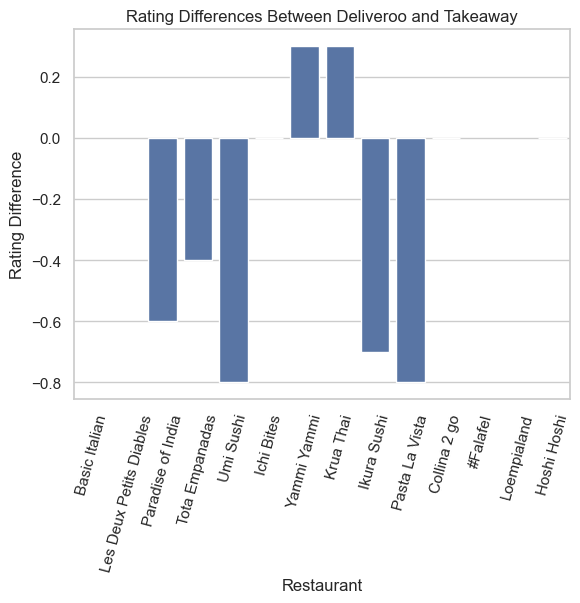

In [40]:
sns.barplot(data, x="name_db1", y="rating_diff_db2_db3")
plt.xticks(rotation=75)
plt.title("Rating Differences Between Deliveroo and Takeaway")
plt.ylabel("Rating Difference")
plt.xlabel("Restaurant")
plt.show()

## 12 WHO ??


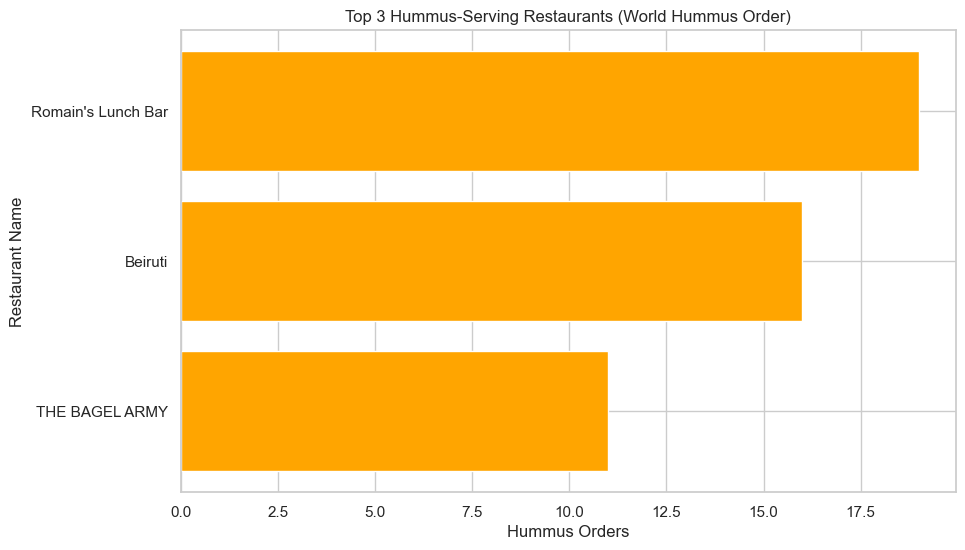

        restaurant_name  hummus_orders
290  Romain's Lunch Bar             19
39              Beiruti             16
311      THE BAGEL ARMY             11


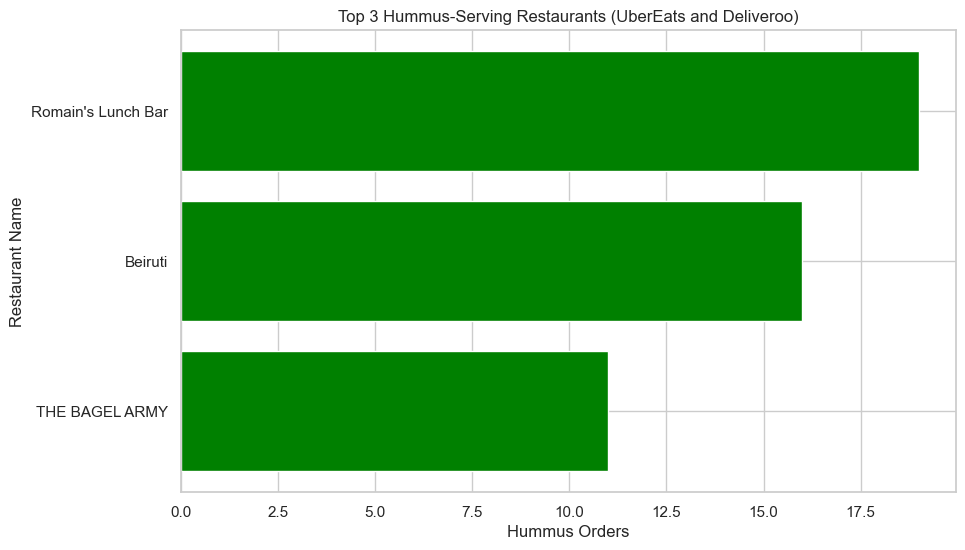

,restaurant_name,hummus_orders
290,Romain's Lunch Bar,19
39,Beiruti,16
311,THE BAGEL ARMY,11


In [41]:
import sqlite3

# File paths for the uploaded databases
ubereats_path = "./databases/ubereats.db"
takeaway_path = "./databases/takeaway.db"
deliveroo_path = "./databases/deliveroo.db"


# Function to fetch the schema of a database
def fetch_schema(db_path):
    with sqlite3.connect(db_path) as conn:
        query = "SELECT name FROM sqlite_master WHERE type='table';"
        tables = conn.execute(query).fetchall()
        schema = {}
        for table in tables:
            table_name = table[0]
            columns = conn.execute(f"PRAGMA table_info({table_name})").fetchall()
            schema[table_name] = [
                (col[1], col[2]) for col in columns
            ]  # Column name and type
        return schema


# Fetch schemas for the databases
ubereats_schema = fetch_schema(ubereats_path)
takeaway_schema = fetch_schema(takeaway_path)
deliveroo_schema = fetch_schema(deliveroo_path)

ubereats_schema, takeaway_schema, deliveroo_schema


# Function to extract hummus data from a database
def fetch_hummus_data(
    db_path,
    menu_table,
    restaurant_table,
    menu_name_col,
    restaurant_id_col,
    restaurant_name_col,
):
    with sqlite3.connect(db_path) as conn:
        # Query for hummus items in the menu
        query = f"""
        SELECT r.{restaurant_name_col} AS restaurant_name, COUNT(*) AS hummus_orders
        FROM {menu_table} m
        JOIN {restaurant_table} r
        ON m.{restaurant_id_col} = r.id
        WHERE LOWER(m.{menu_name_col}) LIKE '%hummus%'
        GROUP BY r.{restaurant_name_col}
        """
        return pd.read_sql_query(query, conn)


# Function to fetch hummus data specifically for takeaway.db
def fetch_hummus_data_takeaway(db_path, menu_table, menu_name_col):
    with sqlite3.connect(db_path) as conn:
        # Query for hummus items in the menu (without join)
        query = f"""
        SELECT {menu_name_col} AS dish_name, COUNT(*) AS hummus_orders
        FROM {menu_table}
        WHERE LOWER({menu_name_col}) LIKE '%hummus%'
        GROUP BY {menu_name_col}
        """
        return pd.read_sql_query(query, conn)


# Fetch hummus data from takeaway.db using the revised approach
takeaway_hummus = fetch_hummus_data_takeaway(takeaway_path, "menuItems", "name")
takeaway_hummus

# Extract hummus data from all three databases
ubereats_hummus = fetch_hummus_data(
    ubereats_path, "menu_items", "restaurants", "name", "restaurant_id", "title"
)
# takeaway_hummus = fetch_hummus_data(takeaway_path, "menuItems", "restaurants", "name", "restaurant_id", "name")
deliveroo_hummus = fetch_hummus_data(
    deliveroo_path, "menu_items", "restaurants", "name", "restaurant_id", "name"
)

# Combine the data from all sources
all_hummus_data = pd.concat(
    [ubereats_hummus, takeaway_hummus, deliveroo_hummus], ignore_index=True
)

# Aggregate orders by restaurant
top_hummus_restaurants = all_hummus_data.groupby(
    "restaurant_name", as_index=False
).sum()
top_hummus_restaurants = top_hummus_restaurants.sort_values(
    by="hummus_orders", ascending=False
).head(3)

# Visualize the top 3 hummus-serving restaurants
plt.figure(figsize=(10, 6))
plt.barh(
    top_hummus_restaurants["restaurant_name"],
    top_hummus_restaurants["hummus_orders"],
    color="orange",
)
plt.xlabel("Hummus Orders")
plt.ylabel("Restaurant Name")
plt.title("Top 3 Hummus-Serving Restaurants (World Hummus Order)")
plt.gca().invert_yaxis()  # Invert y-axis for ranking order
plt.show()

top_hummus_restaurants


# Inspect columns of `menuItems` and `restaurants` tables in takeaway.db
with sqlite3.connect(takeaway_path) as conn:
    menu_items_columns = conn.execute("PRAGMA table_info(menuItems);").fetchall()
    restaurants_columns = conn.execute("PRAGMA table_info(restaurants);").fetchall()

menu_items_columns, restaurants_columns


# Re-fetch hummus data from UberEats and Deliveroo databases only
ubereats_hummus = fetch_hummus_data(
    ubereats_path, "menu_items", "restaurants", "name", "restaurant_id", "title"
)
deliveroo_hummus = fetch_hummus_data(
    deliveroo_path, "menu_items", "restaurants", "name", "restaurant_id", "name"
)

# Combine the data from UberEats and Deliveroo
filtered_hummus_data = pd.concat([ubereats_hummus, deliveroo_hummus], ignore_index=True)

# Aggregate orders by restaurant
top_hummus_restaurants_filtered = filtered_hummus_data.groupby(
    "restaurant_name", as_index=False
).sum()
top_hummus_restaurants_filtered = top_hummus_restaurants_filtered.sort_values(
    by="hummus_orders", ascending=False
).head(3)
print(top_hummus_restaurants_filtered)
# Visualize the top 3 hummus-serving restaurants
plt.figure(figsize=(10, 6))
plt.barh(
    top_hummus_restaurants_filtered["restaurant_name"],
    top_hummus_restaurants_filtered["hummus_orders"],
    color="green",
)
plt.xlabel("Hummus Orders")
plt.ylabel("Restaurant Name")
plt.title("Top 3 Hummus-Serving Restaurants (UberEats and Deliveroo)")
plt.gca().invert_yaxis()  # Invert y-axis for ranking order
plt.show()

top_hummus_restaurants_filtered